In [3]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

import gymnasium as gym


plt.rcParams["figure.figsize"] = (10, 5)


In [32]:
class FFBlock(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()

        self.block = nn.Sequential(
            nn.Linear(n_hidden, n_hidden // 2),
            nn.Tanh(),
            nn.Linear(n_hidden // 2, n_hidden),
            nn.LayerNorm(n_hidden),
            # nn.Dropout(0.1)
        )

    def forward(self, x):
        out = x + self.block(x)
        return out

class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden = 16  # Nothing special with 16, feel free to change
        layers = 3

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden),
            *[FFBlock(hidden) for _ in range(layers)],
            nn.Linear(hidden, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """

        action_logits = self.shared_net(x)

        return action_logits

In [33]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-1  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_logits = self.net(state)
        
        potentials = F.softmax(action_logits, dim=1)
        # print(potentials)

        action = torch.multinomial(potentials, 1)[0].item()
        # print(action)

        self.probs.append(torch.log(potentials[0][action]))

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

In [34]:
# Create and wrap the environment
env = gym.make("LunarLander-v2")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(1e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = 4 #env.action_space
rewards_over_seeds = []

agent = REINFORCE(obs_space_dims, action_space_dims)
# agent.learning_rate = 1e-8


for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    # agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 250 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

Episode: 0 Average Reward: -509
Episode: 250 Average Reward: -152
Episode: 500 Average Reward: -152
Episode: 750 Average Reward: -152
Episode: 0 Average Reward: -151
Episode: 250 Average Reward: -115
Episode: 500 Average Reward: -115


KeyboardInterrupt: 

In [12]:
print(obs)

[ 1.6483497e-02 -1.8323898e-04 -2.3143215e-03  5.7386495e-07
  2.7363941e-03  6.8563502e-04  1.0000000e+00  1.0000000e+00]


In [81]:
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(3000):
   action = agent.sample_action(observation) # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

In [80]:
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)

agent2 = REINFORCE(obs_space_dims, action_space_dims)

for _ in range(10000):
   action = agent2.sample_action(observation) # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

KeyboardInterrupt: 

In [8]:
env = gym.make("LunarLander-v2", render_mode="human")

In [11]:
env.observation_space.shape

(8,)

/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

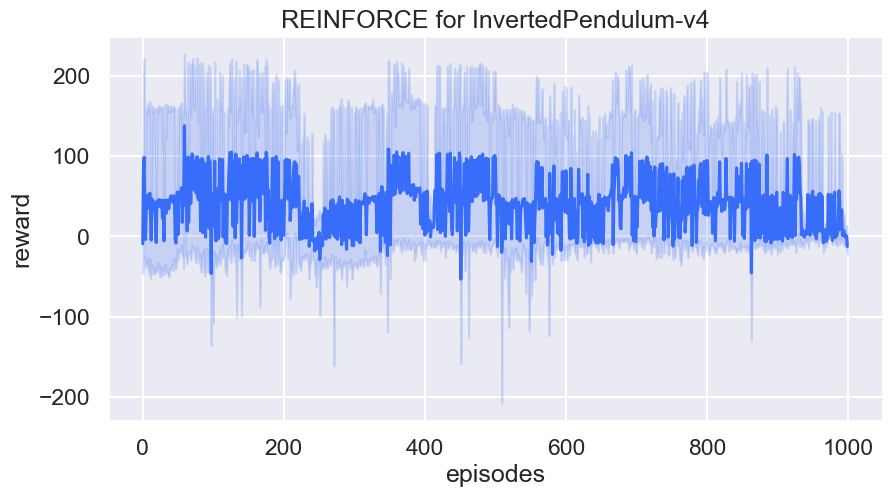

In [31]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()

In [36]:
torch.multinomial(torch.tensor([0.5,0.25,0.25]),1)[0].item()

0